#### Analysing Residuals to build better models

**Author:** Andrew Kruchko

**Contributors:** Thodoris Petropoulos

**Label:** Regression

**Scope**: The scope of this notebook is to provide a short overview on how to check residuals and improve the model results.

**Requirements:** Python 3.8; DataRobot python client version 2.22.1

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datarobot as dr
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

#### Connect to DataRobot

In [2]:
dr.Client(config_path="../../drconfig.yaml")

#### Define Functions

In [3]:
def rmse(target, predictions):
    return np.sqrt(mean_squared_error(target, predictions))

In [4]:
def get_frozen_model(proj, blueprint):
    frozen_models = [m.get_frozen_child_models() for m in proj.get_models() if m.blueprint_id == blueprint.id]
    frozen_models = [model for models in frozen_models for model in models]
    if len(frozen_models):
        return frozen_models[0]
    else:
        # train the model on 64% sample
        model_job_id = proj.train(blueprint.id, sample_pct=64, scoring_type=dr.enums.SCORING_TYPE.cross_validation)
        model_job = dr.ModelJob.from_id(proj.id, model_job_id)
        model_job.wait_for_completion(max_wait=1800)
        model = dr.ModelJob.get_model(proj.id, model_job_id)

        # retrain the model on the whole dataset with fixed parameters
        model_job = model.request_frozen_model(sample_pct=100)
        model_job.wait_for_completion(max_wait=1800)

        return dr.Model.get(proj.id, model_job.model_id)

In [5]:
def get_residuals(proj, model, dataset_id, trans_func=None):
    # request external test to compute metric scores and insights on dataset
    external_test_job = model.request_external_test(dataset_id)
    
    # once job is complete, scores and insights are ready for retrieving
    external_test_job.wait_for_completion()
    
    # retrieving list of residuals charts on multiple datasets
    residuals_list = dr.ExternalResidualsChart.list(proj.id, model.id)
    
    # retrieving one residuals chart for dataset
    residuals = dr.ExternalResidualsChart.get(proj.id, model.id, dataset_id)
    
    df_residuals = pd.DataFrame(residuals.data, columns=['price', 'prediction', 'residual', 'rowId'])
    if trans_func is not None:
        # df_residuals.price = trans_func(df_residuals.price)
        df_residuals.prediction = trans_func(df_residuals.prediction)
        df_residuals.residual = df_residuals.prediction - df_residuals.price
        
    df_residuals['residual_stand'] = (df_residuals.residual - df_residuals.residual.mean()) / df_residuals.residual.std()
    
    return df_residuals

In [6]:
def plot_residuals(df):
    print(f'RMSE: {round(rmse(df["price"], df["prediction"]))}\n')
    fig, axs = plt.subplots(1, 2, figsize=(15,6))
    
    # plot predictions vs price
    axs[0].scatter(df.prediction, df.price)
    lims = [
        np.min([axs[0].get_xlim(), axs[0].get_ylim()]),  # min of both axes
        np.max([axs[0].get_xlim(), axs[0].get_ylim()]),  # max of both axes
    ]
    axs[0].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axs[0].set_xlabel('Prediction')
    axs[0].set_ylabel('Price')
    axs[0].set_xlim(lims)
    axs[0].set_ylim(lims)
    
    # plot predictions vs standardized residuals
    axs[1].scatter(df.prediction, y=df.residual_stand)
    axs[1].set_xlabel('Prediction')
    axs[1].set_ylabel('Standardized Residual')
    axs[1].plot(lims, [0, 0], 'k-', alpha=0.75, zorder=0)

In [7]:
def run_model(proj, search_bp, dataset_id, trans_func=None, show_plot=True):
    blueprints = proj.get_blueprints()
    blueprint = [bp for bp in blueprints if search_bp in bp.model_type.lower()][0]
    model_100 = get_frozen_model(proj, blueprint)
    residuals = get_residuals(proj, model_100, dataset_id, trans_func)
    if show_plot:
        plot_residuals(residuals)
    return model_100, residuals

In [8]:
def create_project(data_path, project_name, metric):
    # create a projects and run it in manual mode
    project = dr.Project.create(data_path, 
                                project_name=project_name + metric)

    project.set_target(target=target,
                       metric=metric,
                       mode=dr.enums.AUTOPILOT_MODE.MANUAL,
                       worker_count=-1)

    project.unlock_holdout()
    
    return project

#### Dataset

We're going to use cleaned 100,000 UK Used Car Data from [Kaggle](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes).

It contains information of price, transmission, mileage, year, manufacturer, model, fuel type, road tax, miles per gallon (mpg), and engine size.

The 500 rows holdout sample was created to compute predictions and residuals.

In [9]:
target = 'price'

In [10]:
df = pd.read_csv('data/uk_used_cars.csv')

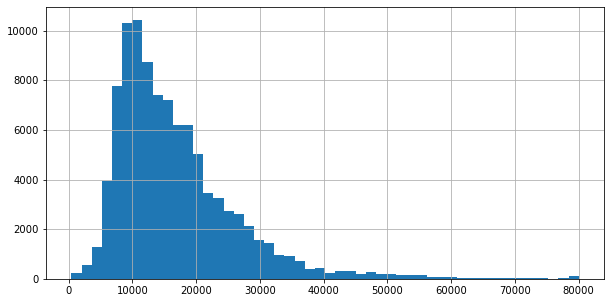

In [11]:
# the target is skewed as expected.
_ = df[target].clip(0, 80_000).hist(bins=50, figsize=(10, 5))

#### Residuals

**Residual = Predicted - Observed**

Positive values for the residual mean the prediction was too high, negative values mean the prediction was too low.

In general the plot of the residuals looks like the plot below:

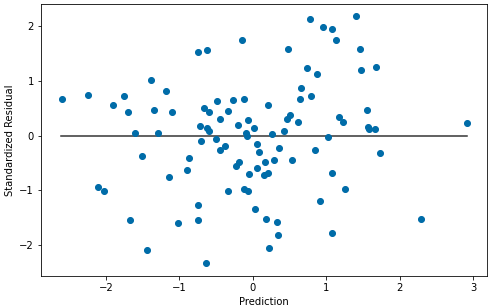

- the residuals should be symmetrically distributed, tending to cluster towards the middle of the plot.
- there shouldn't be any clear patterns.

#### Create simple model and get residuals based the on external holdout dataset

In [12]:
project = create_project('data/uk_used_cars.csv', 'UK_used_cars_', 'RMSE')

# upload external holdout dataset
dataset = project.upload_dataset('data/uk_used_cars_scoring.csv')

RMSE: 3431



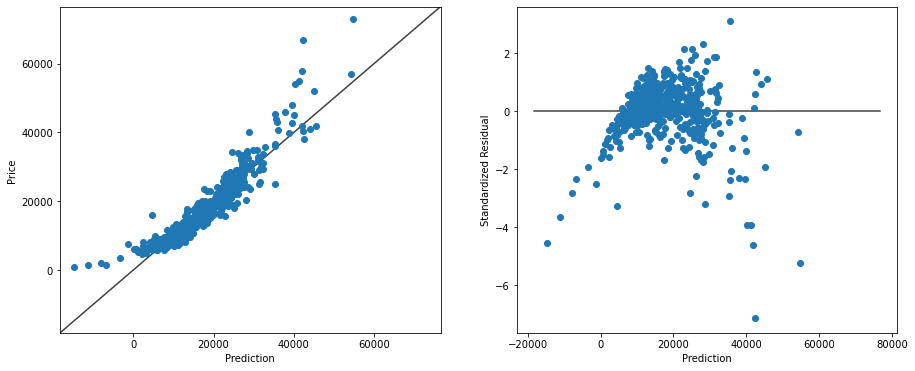

In [13]:
# let's run a linear regression to start
results_lr = run_model(project, 'linear regression', dataset.id)

Based on the plot above, the residuals are not symmetrically distributed and there's constant underprediction for small and high target values.

#### Improving the results

1. A nonlinear model
2. Change the metric to optimize
3. Model factory

#### 1. A nonlinear model
A nonlinear model should capture more complex interactions between variables.

RMSE: 1500



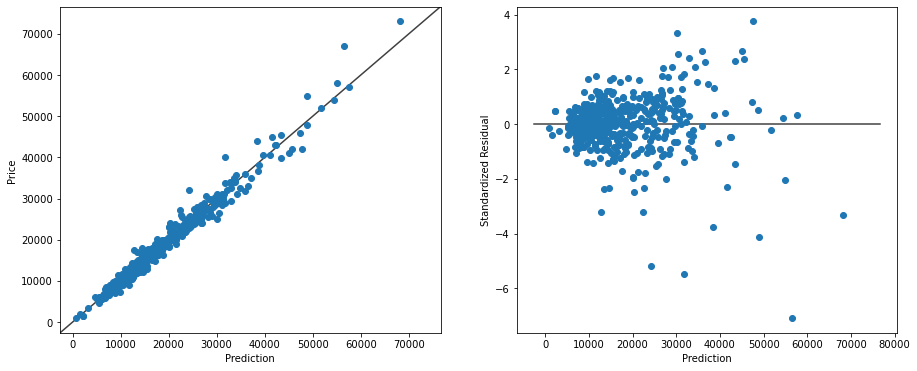

In [14]:
results_xgb = run_model(project, 'extreme gradient boosted trees', dataset.id)

The residuals are more symmetrically distributed and there are not clear patterns.

#### 2. Change the metric to optimize

Since the target distribution is skewed we can try to change the metric to RMSLE. It's only applicable if the target >= 0 and equivalent to np.log1p transformation of the target with RMSE as the metric. Note that only the percent difference between the actual and prediction matter.  For example, P = 1000 and A = 500 would give the roughly same error as when P = 100000 and A = 50000.

In [15]:
project_rmsle = create_project('data/uk_used_cars.csv', 'UK_used_cars_', 'RMSLE')
dataset_rmsle = project_rmsle.upload_dataset('data/uk_used_cars_scoring.csv')

True


RMSE: 2533



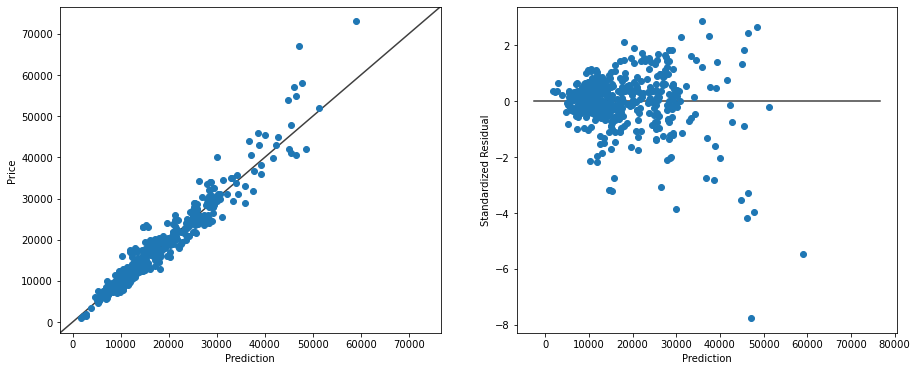

In [16]:
results_lr_rmsle = run_model(project_rmsle, 'linear regression', dataset_rmsle.id)

The results are not ideal, but become better compared to the initial plots.

#### 3. Model factory

The dataset contains car prices of different manufacturers. Splitting the dataset into smaller based on manufacturer groups by car prices may help to improve the results.

In [17]:
project_group1 = create_project('data/uk_used_cars_group1.csv', 'UK_used_cars_group1_', 'RMSE')
dataset_group1 = project_group1.upload_dataset('data/uk_used_cars_scoring_group1.csv')

project_group2 = create_project('data/uk_used_cars_group2.csv', 'UK_used_cars_group2_', 'RMSE')
dataset_group2 = project_group2.upload_dataset('data/uk_used_cars_scoring_group2.csv')

In [18]:
results_lr_group1 = run_model(project_group1, 'linear regression', dataset_group1.id, show_plot=False)
results_lr_group2 = run_model(project_group2, 'linear regression', dataset_group2.id, show_plot=False)

In [19]:
residuals_combined = pd.concat([results_lr_group1[1], results_lr_group2[1]], axis=0, ignore_index=True)

RMSE: 3065



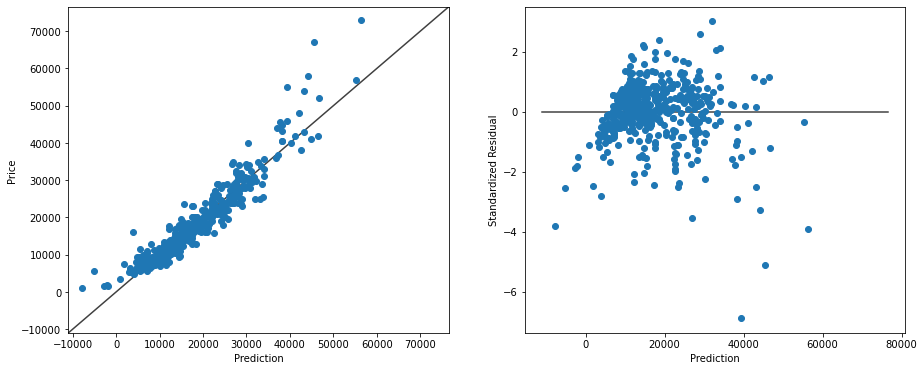

In [20]:
plot_residuals(residuals_combined)

The results are similar to the initial, but the patterns are less clear.

#### Summary

- in our example the nonlinear model has shown the best results
- changing metric (or the target transformation) also improved the results
- model factory based on the manufacturer groups just slightly improved the results. There're other potential ways to improve it:
    - more granular groups up to models by manufactures
    - groups by cars year
    - groups by cars year and manufacture
    
In general there is no one ideal solution for all uses cases which is why it's sometimes iterative process during improving the model results.